# MNIST 1 Layer FC + Softmax

# Setup

## Imports

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

C:\Users\FMISecretariat6\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load Data

In [2]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data\t10k-labels-idx1-ubyte.gz


## Setup Model

Modelul corespunde unui task de clasificare + soft-max peste datasetul MNIST

![](../images/model.png)

Se ia fiecare imagine `28 x 28`, se vectorizeaza `784` si se ataseaza fully-connected unui layer cu 10 noduri softmax (clasificatorul) 

Definim intai toate valorile dimensiunilor, pentru claritate





In [3]:
batchSize = None;       # None pentru ca nu stim inca dimensiunea unui Batch
imgHeight = 28
imgWidth = 28
numOfColors = 1         # pentru imagini color, numOfColors = 3 RGB
flatSize = imgHeight*imgWidth*numOfColors   # 728
numberOfClasses = 10    # 10 clase: 0-9

Acum putem sa ne definim variabilele. Imagini de input :`X_img`:

In [4]:
# Input Data
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")

X_img este un tensor (pe care ni-l putem imagina ca un set de imagini stacked vertical intr-un tabel de lungime `batchSize`). X[0,:,:,:] este prima imagine

X_img trebuie vectorizat/reshaped, pentru ultimul layer de FC, in X_vec. 

**Nota**: Daca o componenta a dimensiunilor este valoarea speciala "-1" , valoarea acelei componente o sa fie inlocuita in asa fel incat dimensiunea totala sa ramana constanta. Maxim o componenta poate sa fie "-1".

In [5]:
X_vec = tf.reshape(X_img, [-1, 784], name="X_vec")

`X_vec` devine $28*28*1 = 784$

![](../images/x_vec.png)


Definim weights si biases:

In [6]:
# Weights
W = tf.Variable(tf.zeros([flatSize, numberOfClasses]), name="Weights")

# Biases
b = tf.Variable(tf.zeros([10]), name="Biases")

`X_vec` este $100 \times 784$,  `W` este $784 \times 10$ =>>>> produce $100 \times 10$, - i.e - cat de mult apartin cele 100 de imagini celor 10 clase? 

**Note**: Antrenam aceste W si b pentru a obtine un rezultat precis la aceasta intrebare.

Initializarea variabilelor : (deprecated)

In [7]:
init = tf.global_variables_initializer()

Activarea pentru layerul FC:

![](../images/output.png)

In [8]:
Y_Pred_Prob = tf.nn.softmax(tf.matmul(X_vec, W) + b, name="softmax")

Definim un placeholder pentru probabilitatile de apartentanta la clasa. Folosim "None" ca prima dimensiune pentru ca o sa fie automat prelucrate batchSize imagini, indiferent de cat de mare este batchSize.

In [9]:
Y_True_Prob = tf.placeholder(tf.float32, [None, 10], name="Y_True")

Pentru masurarea distantei intre GT si Predictii, calculam loss'ul cross-entropy : 

![](../images/cross_entropy_loss.png)

In [40]:
cross_entropy_loss = -tf.reduce_sum(Y_True_Prob * tf.log(Y_Pred_Prob), name="Loss_Cross_Entropy")

Calculam predictiile din fiecare vector de 10 elemente, considerand maximul ca fiind "cea mai puternica" incredere in acea clasa

In [41]:
Y_Pred_Class = tf.argmax(Y_Pred_Prob,1, name="Y_Pred_Class")
Y_True_Class = tf.argmax(Y_True_Prob,1, name="Y_True_Class")   # there is only 1 non-zero index

Astfel, putem sa calculam metrici de acuratete : 

In [42]:
is_correct = tf.equal(Y_Pred_Class, Y_True_Class, name="calcCorrect")

accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32), name="calcAccuracy")

# Antrenare

Setup pentru optimizator. Dam ca parametru functia de cost.

In [53]:
alpha = 0.003                          # rata de invatare / learning rate

optimizer = tf.train.GradientDescentOptimizer(alpha, name="optimizer")

trainStep = optimizer.minimize(cross_entropy_loss, name="trainStep")

**run** pe graful computational creat, in mini-batchuri de cate 100

In [54]:
numberOfBatches = 10000
batchSize = 100

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

In [55]:
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # setup this batches input dictionary
        train_data = {X_img: batch_X, Y_True_Prob: batch_Y}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)
        

        # compute this batches success on the training data
        trainAcc,trainLoss = sess.run([accuracy, cross_entropy_loss], feed_dict=train_data)

        if i%100 == 0:
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True_Prob: mnist.test.labels}
            testAcc,testLoss = sess.run([accuracy, cross_entropy_loss], feed_dict=test_data)
            print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)

Train 0: accuracy:0.5 loss: 180.41948
Test 0: accuracy:0.3226 loss: 20790.416
Train 100: accuracy:0.88 loss: 46.840576
Test 100: accuracy:0.8841 loss: 4268.7656
Train 200: accuracy:0.94 loss: 29.140974
Test 200: accuracy:0.902 loss: 3617.795
Train 300: accuracy:0.92 loss: 35.79937
Test 300: accuracy:0.9061 loss: 3412.7217
Train 400: accuracy:0.9 loss: 45.29678
Test 400: accuracy:0.9085 loss: 3288.1511
Train 500: accuracy:0.95 loss: 26.759539
Test 500: accuracy:0.9121 loss: 3174.2805
Train 600: accuracy:0.95 loss: 17.974377
Test 600: accuracy:0.914 loss: 3129.609
Train 700: accuracy:0.93 loss: 28.792688
Test 700: accuracy:0.9152 loss: 3066.0227
Train 800: accuracy:0.96 loss: 26.375303
Test 800: accuracy:0.9158 loss: 3031.6387
Train 900: accuracy:0.94 loss: 25.576122
Test 900: accuracy:0.9121 loss: 3066.3032
Train 1000: accuracy:0.93 loss: 25.429909
Test 1000: accuracy:0.917 loss: 2994.3804
Train 1100: accuracy:0.91 loss: 30.02734
Test 1100: accuracy:0.9187 loss: 2949.6846
Train 1200: ac

Train 9800: accuracy:0.92 loss: 20.624443
Test 9800: accuracy:0.9253 loss: 2697.631
Train 9900: accuracy:0.96 loss: 13.184711
Test 9900: accuracy:0.925 loss: 2711.3738


# Plotting

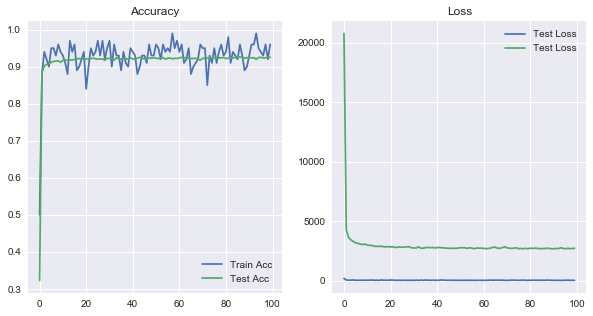

In [57]:
plt.figure(figsize=(10,5))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();